<a href="https://colab.research.google.com/github/ricospeloacaso/python_para_investimentos/blob/master/26_Analisando_Fundos_de_Investimento_com_Python_Os_Melhores_e_os_Piores_de_2020S1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Python para Investimentos -  Analisando Fundos de Investimento com Python - Os Melhores e os Piores de 2020S1

**Canal no Youtube:** https://www.youtube.com/ricospeloacaso?sub_confirmation=1

Link para o Vídeo: https://youtu.be/YjvNggnKF-A

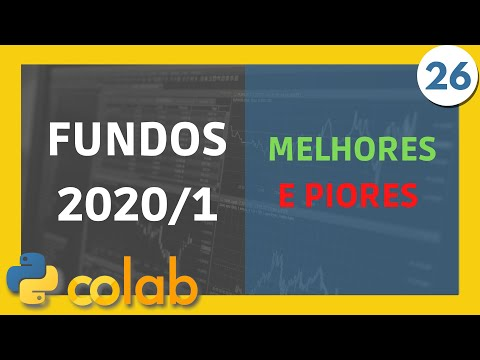

In [1]:
#@title Vídeo
from IPython.display import YouTubeVideo
YouTubeVideo('YjvNggnKF-A', width=854, height=480)

*   Base de Dados: http://dados.cvm.gov.br/




## Módulos

In [ ]:
!pip install -q yfinance

In [ ]:
#Cotações do Yahoo Finance
import yfinance as yf

# Tratamento de Dados
import pandas as pd
from pandas.tseries.offsets import BDay
pd.set_option("display.max_colwidth", 150)

#Gráficos
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

#Utilidades
from datetime import date

## Funções

In [ ]:
def busca_cadastro_cvm(data=(date.today()-BDay(2))):
  if data is not busca_cadastro_cvm.__defaults__[0]:
    data = pd.to_datetime(data)
  
  try:
    url = 'http://dados.cvm.gov.br/dados/FI/CAD/DADOS/inf_cadastral_fi_{}{:02d}{:02d}.csv'.format(data.year, data.month, data.day)
    return pd.read_csv(url, sep=';', encoding='ISO-8859-1')

  except: 
    print("Arquivo {} não encontrado!".format(url))
    print("Forneça outra data!")

In [ ]:
def busca_informes_diarios_cvm_por_periodo(data_inicio, data_fim):
  datas = pd.date_range(data_inicio, data_fim, freq='MS') 
  informe_completo = pd.DataFrame()

  for data in datas:
    try:
      url ='http://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/inf_diario_fi_{}{:02d}.csv'.format(data.year, data.month)
      informe_mensal = pd.read_csv(url, sep=';')    
    
    except: 
      print("Arquivo {} não encontrado!".format(url))    

    informe_completo = pd.concat([informe_completo, informe_mensal], ignore_index=True)

  return informe_completo

In [ ]:
def melhores_e_piores(informes, cadastro, top=5, minimo_de_cotistas=100, classe=''):  
  cadastro      = cadastro[cadastro['SIT'] == 'EM FUNCIONAMENTO NORMAL']
  fundos        = informes[informes['NR_COTST'] >= minimo_de_cotistas]
  cnpj_informes = fundos['CNPJ_FUNDO'].drop_duplicates()
  
  fundos = fundos.pivot(index='DT_COMPTC', columns='CNPJ_FUNDO')  
  cotas_normalizadas = fundos['VL_QUOTA'] / fundos['VL_QUOTA'].iloc[0]
  
  if classe == 'multimercado':
    cnpj_cadastro      = cadastro[cadastro['CLASSE'] == 'Fundo Multimercado']['CNPJ_FUNDO']   
    cotas_normalizadas = cotas_normalizadas[cnpj_cadastro[cnpj_cadastro.isin(cnpj_informes)]]

  if classe == 'acoes':
    cnpj_cadastro      = cadastro[cadastro['CLASSE'] == 'Fundo de Ações']['CNPJ_FUNDO']   
    cotas_normalizadas = cotas_normalizadas[cnpj_cadastro[cnpj_cadastro.isin(cnpj_informes)]]

  if classe == 'rendafixa':
    cnpj_cadastro      = cadastro[cadastro['CLASSE'] == 'Fundo de Renda Fixa']['CNPJ_FUNDO']   
    cotas_normalizadas = cotas_normalizadas[cnpj_cadastro[cnpj_cadastro.isin(cnpj_informes)]]

  if classe == 'cambial':
    cnpj_cadastro      = cadastro[cadastro['CLASSE'] == 'Fundo Cambial']['CNPJ_FUNDO']   
    cotas_normalizadas = cotas_normalizadas[cnpj_cadastro[cnpj_cadastro.isin(cnpj_informes)]]
  
  #melhores
  melhores = pd.DataFrame()
  melhores['retorno(%)'] = (cotas_normalizadas.iloc[-1].sort_values(ascending=False)[:top] - 1) * 100
  for cnpj in melhores.index:
    fundo = cadastro[cadastro['CNPJ_FUNDO'] == cnpj]
    melhores.at[cnpj, 'Fundo de Investimento'] = fundo['DENOM_SOCIAL'].values[0]
    melhores.at[cnpj, 'Classe']                = fundo['CLASSE'].values[0]
    melhores.at[cnpj, 'PL']                    = fundo['VL_PATRIM_LIQ'].values[0]

  #piores
  piores = pd.DataFrame()
  piores['retorno(%)'] = (cotas_normalizadas.iloc[-1].sort_values(ascending=True)[:top] - 1) * 100
  for cnpj in piores.index:
    fundo = cadastro[cadastro['CNPJ_FUNDO'] == cnpj]
    piores.at[cnpj, 'Fundo de Investimento'] = fundo['DENOM_SOCIAL'].values[0]
    piores.at[cnpj, 'Classe']                = fundo['CLASSE'].values[0]
    piores.at[cnpj, 'PL']                    = fundo['VL_PATRIM_LIQ'].values[0]
  
  return melhores, piores

In [ ]:
def consulta_fundo(informes, cnpj):  
  fundo = informes[informes['CNPJ_FUNDO'] == cnpj].copy()
  fundo.set_index('DT_COMPTC', inplace=True)
  fundo['cotas_normalizadas'] = (fundo['VL_QUOTA'] / fundo['VL_QUOTA'].iloc[0])*100
  return fundo

In [ ]:
def cdi_acumulado(data_inicio, data_fim):
  codigo_bcb = 12
  
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  cdi = pd.read_json(url)
  cdi['data'] = pd.to_datetime(cdi['data'], dayfirst=True)
  cdi.set_index('data', inplace=True) 
  
  cdi_acumulado = (1 + cdi[data_inicio : data_fim] / 100).cumprod()
  cdi_acumulado.iloc[0] = 1
  return cdi_acumulado

## Benckmarks

In [ ]:
cdi = cdi_acumulado('2020-01-01', '2020-06-30') * 100
cdi

,valor
data,
2020-01-02,100.000000
2020-01-03,100.034181
2020-01-06,100.051276
2020-01-07,100.068374
2020-01-08,100.085474
...,...
2020-06-24,101.720039
2020-06-25,101.728627
2020-06-26,101.737215


In [ ]:
ibov = yf.download('^BVSP', start='2020-01-02', end='2020-06-30')['Adj Close']
ibov = (ibov / ibov.iloc[0])*100

[*********************100%***********************]  1 of 1 completed


## Buscando Dados da CVM

In [ ]:
cadastro = busca_cadastro_cvm()

In [ ]:
informes = busca_informes_diarios_cvm_por_periodo(data_inicio='2020-01', data_fim='2020-06')

## Fundos de Ações

In [ ]:
melhores, piores = melhores_e_piores(informes, cadastro, top=5, minimo_de_cotistas=100, classe='acoes')

In [ ]:
melhores

,retorno(%),Fundo de Investimento,Classe,PL
CNPJ_FUNDO,,,,
13.199.100/0001-30,45.560268,SANTANDER FUNDO DE INVESTIMENTO COLABORADORES MAGAZINE LUIZA AÇÕES,Fundo de Ações,2.960082e+07
19.831.126/0001-36,38.639518,WESTERN ASSET FUNDO DE INVESTIMENTO AÇÕES BDR NÍVEL I,Fundo de Ações,8.923972e+08
34.218.752/0001-45,37.542381,VITREO EXPONENCIAL FUNDO DE INVESTIMENTO EM AÇÕES INVESTIMENTO NO EXTERIOR,Fundo de Ações,1.285020e+08
17.503.172/0001-80,30.365151,FUNDO DE INVESTIMENTO EM AÇÕES CAIXA BDR NÍVEL I,Fundo de Ações,3.167621e+08
34.028.082/0001-02,29.828496,BRADESCO FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO EM AÇÕES BDR NÍVEL I PLUS,Fundo de Ações,7.080198e+07


In [ ]:
piores

,retorno(%),Fundo de Investimento,Classe,PL
CNPJ_FUNDO,,,,
26.648.868/0001-96,-57.049212,ALASKA BLACK FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO EM AÇÕES II - BDR NÍVEL I,Fundo de Ações,3.964925e+08
12.987.743/0001-86,-57.033414,ALASKA BLACK FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO EM AÇÕES - BDR NÍVEL I,Fundo de Ações,1.575839e+09
31.936.857/0001-41,-48.550372,TREND IBOVESPA ALAVANCADO FUNDO DE INVESTIMENTO EM AÇÕES,Fundo de Ações,9.932222e+07
10.869.628/0001-81,-45.931655,BB AÇÕES CIELO FUNDO DE INVESTIMENTO,Fundo de Ações,2.302420e+07
10.590.125/0001-72,-45.657668,BRADESCO FUNDO DE INVESTIMENTO EM AÇÕES CIELO,Fundo de Ações,6.935006e+06


### Graficos

In [ ]:
cotas = pd.DataFrame()
fundos_destaque = pd.concat([melhores, piores])

for cnpj in fundos_destaque.index:
  cotas = pd.concat([cotas, consulta_fundo(informes, cnpj)['cotas_normalizadas']], axis=1)

cotas.columns = fundos_destaque['Fundo de Investimento']

In [ ]:
cotas

Fundo de Investimento,SANTANDER FUNDO DE INVESTIMENTO COLABORADORES MAGAZINE LUIZA AÇÕES,WESTERN ASSET FUNDO DE INVESTIMENTO AÇÕES BDR NÍVEL I,VITREO EXPONENCIAL FUNDO DE INVESTIMENTO EM AÇÕES INVESTIMENTO NO EXTERIOR,FUNDO DE INVESTIMENTO EM AÇÕES CAIXA BDR NÍVEL I,BRADESCO FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO EM AÇÕES BDR NÍVEL I PLUS,ALASKA BLACK FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO EM AÇÕES II - BDR NÍVEL I,ALASKA BLACK FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO EM AÇÕES - BDR NÍVEL I,TREND IBOVESPA ALAVANCADO FUNDO DE INVESTIMENTO EM AÇÕES,BB AÇÕES CIELO FUNDO DE INVESTIMENTO,BRADESCO FUNDO DE INVESTIMENTO EM AÇÕES CIELO
DT_COMPTC,,,,,,,,,,
2020-01-02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2020-01-03,99.109282,99.360246,99.431370,100.035432,100.118222,100.218032,100.334866,98.936867,98.732687,98.731229
2020-01-06,99.188695,100.114000,94.492746,100.490856,100.544943,99.763561,100.027711,97.054090,96.299996,96.300721
2020-01-07,98.904221,100.577654,95.698757,100.144504,100.259391,99.619676,99.934559,96.825498,93.539925,93.525508
2020-01-08,101.935660,101.229118,96.034710,100.698569,100.762386,101.314794,101.723626,95.934100,91.449036,91.446565
...,...,...,...,...,...,...,...,...,...,...
2020-06-24,141.821657,134.756773,143.401442,126.654718,125.948062,43.870744,43.876281,50.523964,55.006983,55.243907
2020-06-25,141.596400,135.546686,148.254437,127.660257,127.033177,43.977748,43.982428,52.372393,56.982868,57.239883
2020-06-26,140.905053,136.364231,144.133655,127.808773,127.151502,41.860003,41.884814,49.880526,54.186143,54.441724


In [ ]:
fig = go.Figure()

traces = [go.Scatter(
    x = cotas.index,
    y = cotas[fundo],
    name = fundo
) for fundo in cotas.columns]

fig.add_trace(go.Scatter(x=ibov.index, y=ibov, name='IBOV', line=dict(color='black', width=3)))

fig.add_traces(traces)
fig.update_layout(title='Melhores e Piores Fundos de Ações do 1º Semestre de 2020')
fig.update_layout(legend_orientation="h")

fig.show()

## Fundos Multimercado

In [ ]:
melhores, piores = melhores_e_piores(informes, cadastro, top=5, minimo_de_cotistas=100, classe='multimercado')

In [ ]:
melhores

,retorno(%),Fundo de Investimento,Classe,PL
CNPJ_FUNDO,,,,
34.979.818/0001-10,55.918874,BTG PACTUAL OURO USD FUNDO DE INVESTIMENTO MULTIMERCADO,Fundo Multimercado,1.327900e+08
09.601.190/0001-77,50.524049,ÓRAMA OURO FUNDO DE INVESTIMENTO MULTIMERCADO,Fundo Multimercado,3.263981e+08
33.925.149/0001-30,49.712945,VITREO OURO FUNDO DE INVESTIMENTO EM COTAS DE FUNDO DE INVESTIMENTO MULTIMERCADO,Fundo Multimercado,2.504255e+08
24.454.718/0001-16,38.432565,DOLAR GLOBAL MACRO OPPORTUNITIES FUNDO DE INVESTIMENTO MULTIMERCADO INVESTIMENTO NO EXTERIOR,Fundo Multimercado,1.233533e+08
25.234.721/0001-97,37.303051,BB MULTIMERCADO LP FX BALANCED INVESTIMENTO NO EXTERIOR PRIVATE FUNDO DE INVESTIMENTO,Fundo Multimercado,1.173509e+08


In [ ]:
piores

,retorno(%),Fundo de Investimento,Classe,PL
CNPJ_FUNDO,,,,
24.837.071/0001-01,-75.977031,WM DELTA CRÉDITO ESTRUTURADO FI EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO - CRÉDITO PRIVADO,Fundo Multimercado,1.108438e+06
11.182.072/0001-13,-47.266763,LOGOS TOTAL RETURN FI EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO,Fundo Multimercado,1.717749e+08
31.964.487/0001-56,-38.621635,BTG PACTUAL EQUITY TOF FUNDO DE INVESTIMENTO MULTIMERCADO,Fundo Multimercado,1.199001e+08
19.628.666/0001-17,-35.346868,EXPLORITAS ALPHA AMERICA LATINA FUNDO DE INVESTIMENTO EM COTAS DE FI MULTIMERCADO,Fundo Multimercado,7.247739e+08
27.751.295/0001-94,-34.897007,EXPLORITAS ALPHA AMERICA LATINA FI EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO ACCESS,Fundo Multimercado,1.266131e+07


### Grafico de Cotas

In [ ]:
cotas = pd.DataFrame()
fundos_destaque = pd.concat([melhores, piores])

for cnpj in fundos_destaque.index:
  cotas = pd.concat([cotas, consulta_fundo(informes, cnpj)['cotas_normalizadas']], axis=1)

cotas.columns = fundos_destaque['Fundo de Investimento']

In [ ]:
cotas

In [ ]:
fig = go.Figure()

traces = [go.Scatter(
    x = cotas.index,
    y = cotas[fundo],
    name = fundo
) for fundo in cotas.columns]

fig.add_trace(go.Scatter(x=ibov.index, y=ibov, name='IBOV', line=dict(color='black', width=3, dash='dot')))
fig.add_trace(go.Scatter(x=cdi.index, y=cdi['valor'], name='CDI', line=dict(color='blue', width=3)))

fig.add_traces(traces)
fig.update_layout(
    title='Melhores e Piores Fundos Multimercado do 1º Semestre de 2020', 
    legend_orientation="h",
    autosize=True,   
    height=700,

    )

fig.show()

### Correlação

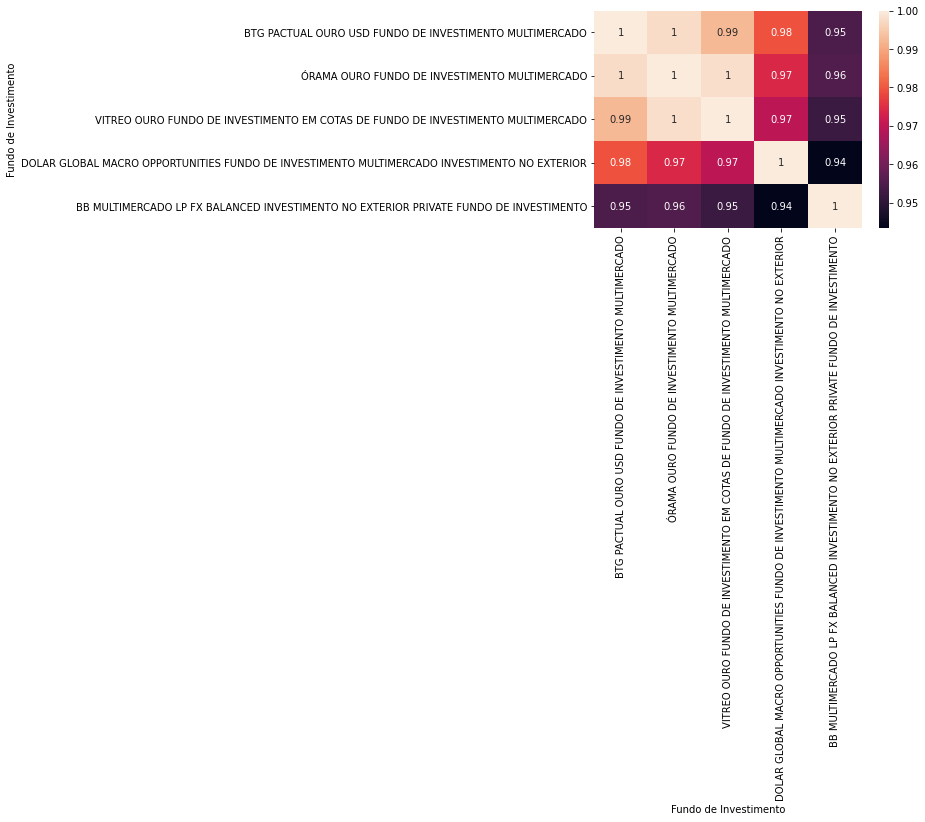

In [ ]:
sns.heatmap(cotas.iloc[:, :5].corr(), annot=True);

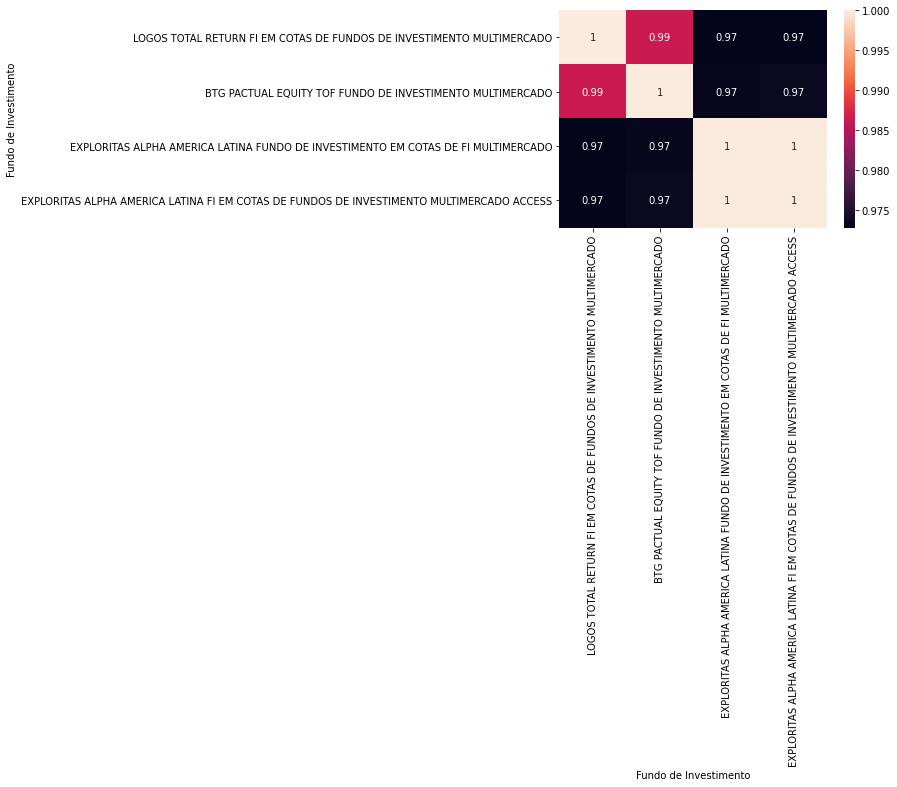

In [ ]:
sns.heatmap(cotas.iloc[:, 6:].corr(), annot=True);